In [1]:
# correlate 100% Tempelhof (2014) and Bundestagswahl (2013)

In [2]:
# module imports
import pandas as pd
import statsmodels.api as sm
import scipy
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from ipynb.fs.full.custom_functions import plot_correlation_matrices, plot_2d_density, plot_residuals

In [3]:
# load THF data into pandas dataframe
thf_raw = pd.read_csv("data/Abstimmung_Tempelhof_2014.csv")
# create unique district ID by concatenating "Bezirksnummer" and "Stimmberzirk"
thf_raw["unique_district"] = thf_raw["Bezirksnummer"].map(str) + thf_raw["Stimmbezirk"].map(str)
# drop all fields but the necessary ones
thf_raw["anteil_ja_thf"] = thf_raw["share-yes"]
thf_raw["participation_thf"] = thf_raw["1 Gültige Stimmen"] / thf_raw["Stimmberechtigte insgesamt"]
thf = thf_raw.filter(['unique_district', 'anteil_ja_thf', 'participation_thf'], axis=1)

In [4]:
# load Bundeatagswahl 2013 data into pandas dataframe
btw13_raw = pd.read_csv("data/Bundestag_2013.csv")
# create unique district ID by concatenating "Bezirksnummer" and "Stimmberzirk"
btw13_raw["unique_district"] = btw13_raw["Bezirksnummer"].map(str) + btw13_raw["Stimmbezirk"].map(str)
btw13_raw["OstWest_color"] = np.where(btw13_raw["OstWest"] == "O", 'red', 'blue')
btw13_raw["OstWest_binary"] = np.where(btw13_raw["OstWest"] == "O", 0, 1)
# transform percent to value between 0 and 1
btw13_raw["linke_prozent"] = btw13_raw["linke_prozent"] / 100
btw13_raw["grüne_prozent"] = btw13_raw["grüne_prozent"] / 100
btw13_raw["spd_prozent"] = btw13_raw["spd_prozent"] / 100
btw13_raw["cdu_prozent"] = btw13_raw["cdu_prozent"] / 100
btw13_raw["fdp_prozent"] = btw13_raw["fdp_prozent"] / 100
btw13_raw["afd_prozent"] = btw13_raw["afd_prozent"] / 100
# btw13_raw["participation_election"] = btw13_raw["gültige_stimmen"] / btw13_raw["stimmberechtigte_insgesamt"]

# drop all fields but the necessary ones
btw_13 = btw13_raw.filter([
    'unique_district',
    'linke_prozent',
    'grüne_prozent',
    'spd_prozent',
    'fdp_prozent',
    'cdu_prozent',
    'afd_prozent',
    'Bezirksnummer',
    'OstWest_color',
    'OstWest_binary',
    # 'participation_election',
], axis=1)

In [5]:
# load THF distance data into pandas dataframe
thf_distance = pd.read_csv("data/thf_full_export.csv")
thf_distance['distance_km'] = thf_distance['distance'] / 1000
thf_distance["unique_district"] = thf_distance["Bezirksnum"].map(str) + thf_distance["Stimmbezir"].map(str)
thf_distance = thf_distance.filter(['unique_district', 'distance_km'], axis=1)

In [6]:
# merge all dfs into one
btw_13_merged = btw_13.merge(
    thf,
    how='inner',
    on='unique_district',
)
btw_13_merged = btw_13_merged.merge(
    thf_distance,
    how='inner',
    on='unique_district',
)
print(btw_13_merged)

     unique_district  linke_prozent  grüne_prozent  spd_prozent  fdp_prozent  \
0               1100          0.177          0.162        0.238        0.017   
1               1101          0.182          0.150        0.262        0.058   
2               1102          0.180          0.120        0.274        0.068   
3               1103          0.180          0.197        0.221        0.070   
4               1104          0.132          0.209        0.224        0.079   
...              ...            ...            ...          ...          ...   
1612           12621          0.049          0.141        0.265        0.051   
1613           12622          0.048          0.098        0.262        0.058   
1614           12623          0.049          0.092        0.268        0.058   
1615           12624          0.032          0.102        0.251        0.038   
1616           12625          0.068          0.064        0.345        0.029   

      cdu_prozent  afd_prozent  Bezirks

In [7]:
# Multiple linear regression for  THF (2014) and Bundestagswahl 2013

# also see: # https://www.sfu.ca/~mjbrydon/tutorials/BAinPy/10_multiple_regression.html

Y = btw_13_merged['anteil_ja_thf']
X = btw_13_merged[[
    'cdu_prozent',
    'spd_prozent',
    'linke_prozent',
    'grüne_prozent',
    'afd_prozent',
    'fdp_prozent',
    'OstWest_binary',
    'distance_km',
    'participation_thf',
]]
X = sm.add_constant(X)
ks = sm.OLS(Y, X)
ks_res = ks.fit()
ks_res.summary()
print(ks_res.summary())

                            OLS Regression Results                            
Dep. Variable:          anteil_ja_thf   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     209.8
Date:                Sun, 30 Jan 2022   Prob (F-statistic):          1.13e-263
Time:                        17:42:35   Log-Likelihood:                 2313.5
No. Observations:                1617   AIC:                            -4607.
Df Residuals:                    1607   BIC:                            -4553.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.5632      0.06

In [8]:
# Scatterplots of all BTW 2013 party results vs. THF individually

# party_map = {
#     'die Linke %': 'linke_prozent',
#     'die Grünen %': 'grüne_prozent',
#     'SPD %': 'spd_prozent',
#     'FDP %': 'fdp_prozent',
#     'CDU %': 'cdu_prozent',
#     'AfD %': 'afd_prozent',
# }
# 
# for party in party_map:
#     fig, ax = plt.subplots(figsize=(8, 8))
#     ax.scatter(data=btw_13_merged, x='anteil_ja_thf', y=party_map[party], c=btw_13_merged["OstWest_color"], s=4)
#     ax.set(title='', xlabel='THF %', ylabel=party)
#     plt.show()

   linke_prozent  grüne_prozent  spd_prozent  fdp_prozent  cdu_prozent  \
0          0.177          0.162        0.238        0.017        0.281   
1          0.182          0.150        0.262        0.058        0.256   
2          0.180          0.120        0.274        0.068        0.266   
3          0.180          0.197        0.221        0.070        0.208   
4          0.132          0.209        0.224        0.079        0.273   

   afd_prozent  anteil_ja_thf  participation_thf  distance_km  
0        0.042          0.624           0.342541     5.441725  
1        0.040          0.619           0.311518     4.156163  
2        0.035          0.765           0.367704     5.314875  
3        0.038          0.574           0.340167     4.138469  
4        0.038          0.815           0.238270     6.162290  


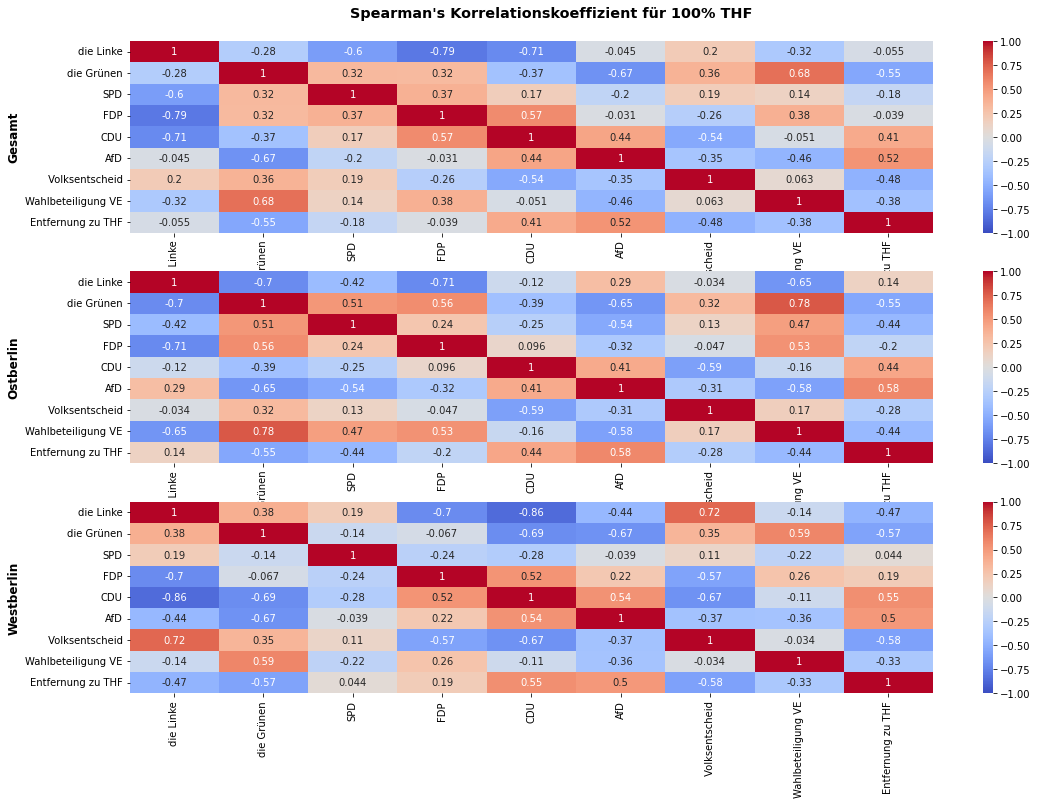

In [9]:
axis_labels = ['die Linke', 'die Grünen', 'SPD', 'FDP', 'CDU', 'AfD', ' Volksentscheid', 'Wahlbeteiligung VE', 'Entfernung zu THF']
plot_correlation_matrices(btw_13_merged, "spearman", "Spearman's", "100% THF", axis_labels)

   linke_prozent  grüne_prozent  spd_prozent  fdp_prozent  cdu_prozent  \
0          0.177          0.162        0.238        0.017        0.281   
1          0.182          0.150        0.262        0.058        0.256   
2          0.180          0.120        0.274        0.068        0.266   
3          0.180          0.197        0.221        0.070        0.208   
4          0.132          0.209        0.224        0.079        0.273   

   afd_prozent  anteil_ja_thf  participation_thf  distance_km  
0        0.042          0.624           0.342541     5.441725  
1        0.040          0.619           0.311518     4.156163  
2        0.035          0.765           0.367704     5.314875  
3        0.038          0.574           0.340167     4.138469  
4        0.038          0.815           0.238270     6.162290  


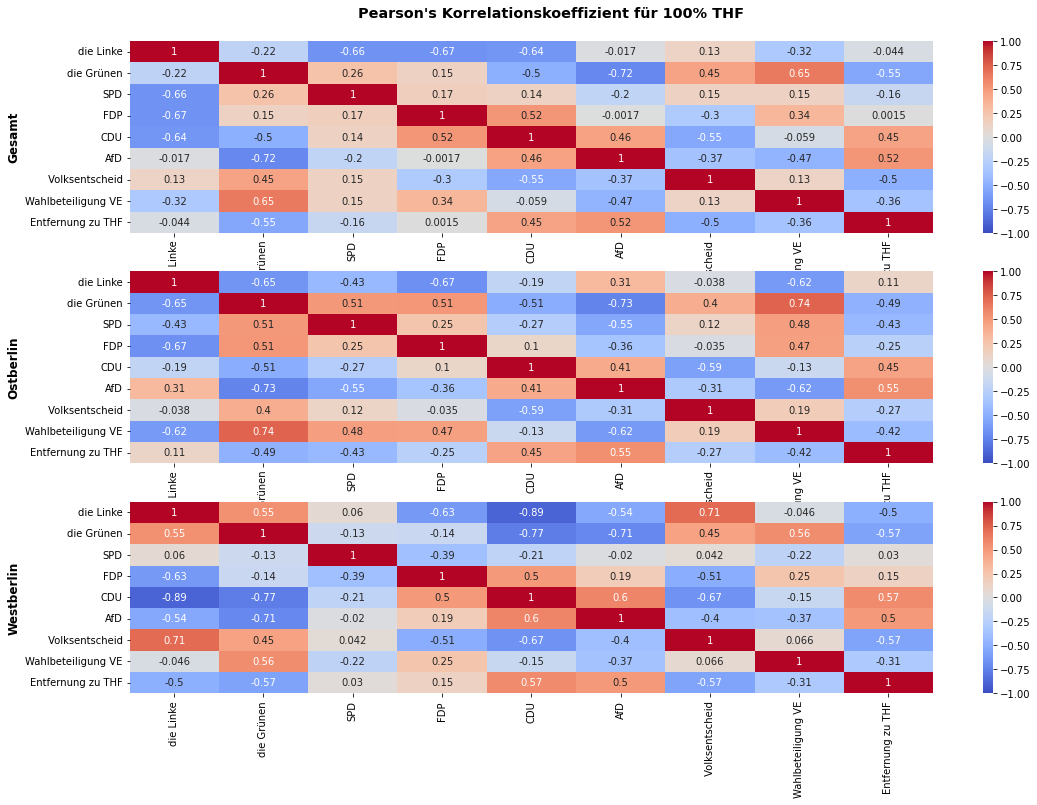

In [10]:
plot_correlation_matrices(btw_13_merged, "pearson", "Pearson's", "100% THF", axis_labels)

In [11]:
# T-test for significant difference between East and West in THF and party results

thf_east = btw_13_merged.loc[btw_13_merged['OstWest_binary'] == 0]
thf_east = thf_east.filter([
    'linke_prozent',
    'grüne_prozent',
    'spd_prozent',
    'fdp_prozent',
    'cdu_prozent',
    'afd_prozent',
    'anteil_ja_thf',
    'participation_thf',
], axis=1)
thf_west = btw_13_merged.loc[btw_13_merged['OstWest_binary'] == 1]
thf_west = thf_west.filter([
    'linke_prozent',
    'grüne_prozent',
    'spd_prozent',
    'fdp_prozent',
    'cdu_prozent',
    'afd_prozent',
    'anteil_ja_thf',
    'participation_thf',
], axis=1)
p_values = scipy.stats.ttest_ind(a=thf_east, b=thf_west)[1]

print("p-Werte der T-Tests auf Unterschiede der Grundgesamtheit zwischen Ost- und Westberlin für...")
print("die LINKE: {}".format(p_values[0].round(3)))
print("die Grünen: {}".format(p_values[1].round(3)))
print("SPD: {}".format(p_values[2].round(3)))
print("FDP: {}".format(p_values[3].round(3)))
print("CDU: {}".format(p_values[4].round(3)))
print("AfD: {}".format(p_values[5].round(3)))
print("Zustimmung THF: {}".format(p_values[6].round(3)))
print("Wahlbeteiligung THF: {}".format(p_values[7].round(3)))


p-Werte der T-Tests auf Unterschiede der Grundgesamtheit zwischen Ost- und Westberlin für...
die LINKE: 0.0
die Grünen: 0.0
SPD: 0.0
FDP: 0.0
CDU: 0.0
AfD: 0.0
Zustimmung THF: 0.0
Wahlbeteiligung THF: 0.0


In [12]:
# calculate relationship between distance and share of yes votes for THF

X = btw_13_merged['distance_km']
Y = btw_13_merged['anteil_ja_thf']

X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          anteil_ja_thf   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     544.2
Date:                Sun, 30 Jan 2022   Prob (F-statistic):          5.59e-104
Time:                        17:42:45   Log-Likelihood:                 1920.2
No. Observations:                1617   AIC:                            -3836.
Df Residuals:                    1615   BIC:                            -3826.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.7616      0.004    198.112      

<AxesSubplot:xlabel='anteil_ja_thf', ylabel='distance_km'>

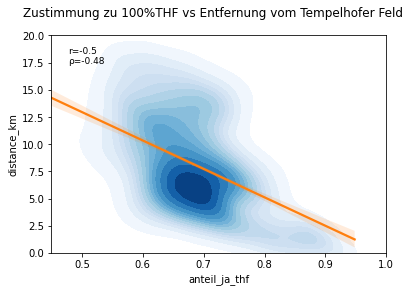

In [13]:
# 2D-density plot of THF results vs. distance to Tempelhofer Feld

fig, ax = plt.subplots()
fig.suptitle('Zustimmung zu 100%THF vs Entfernung vom Tempelhofer Feld')
ax.set(xlim=(0.45,1), ylim=(0, 20))
ax = sb.kdeplot(
    x=btw_13_merged['anteil_ja_thf'], y=btw_13_merged['distance_km'], cmap='Blues',shade=True, ax=ax, levels=15
)

# add correlation coefficients
pearson = btw_13_merged['anteil_ja_thf'].corr(btw_13_merged['distance_km'], method='pearson').round(2)
spearman = btw_13_merged['anteil_ja_thf'].corr(btw_13_merged['distance_km'], method='spearman').round(2)
ax.text(
    0.05, 0.95, "r={pearson}\nρ={spearman}".format(pearson=pearson, spearman=spearman), transform=ax.transAxes, fontsize=9, verticalalignment='top'
)
sb.regplot(
    x=btw_13_merged['anteil_ja_thf'], y=btw_13_merged['distance_km'],order=1, ci=95, scatter=False
)

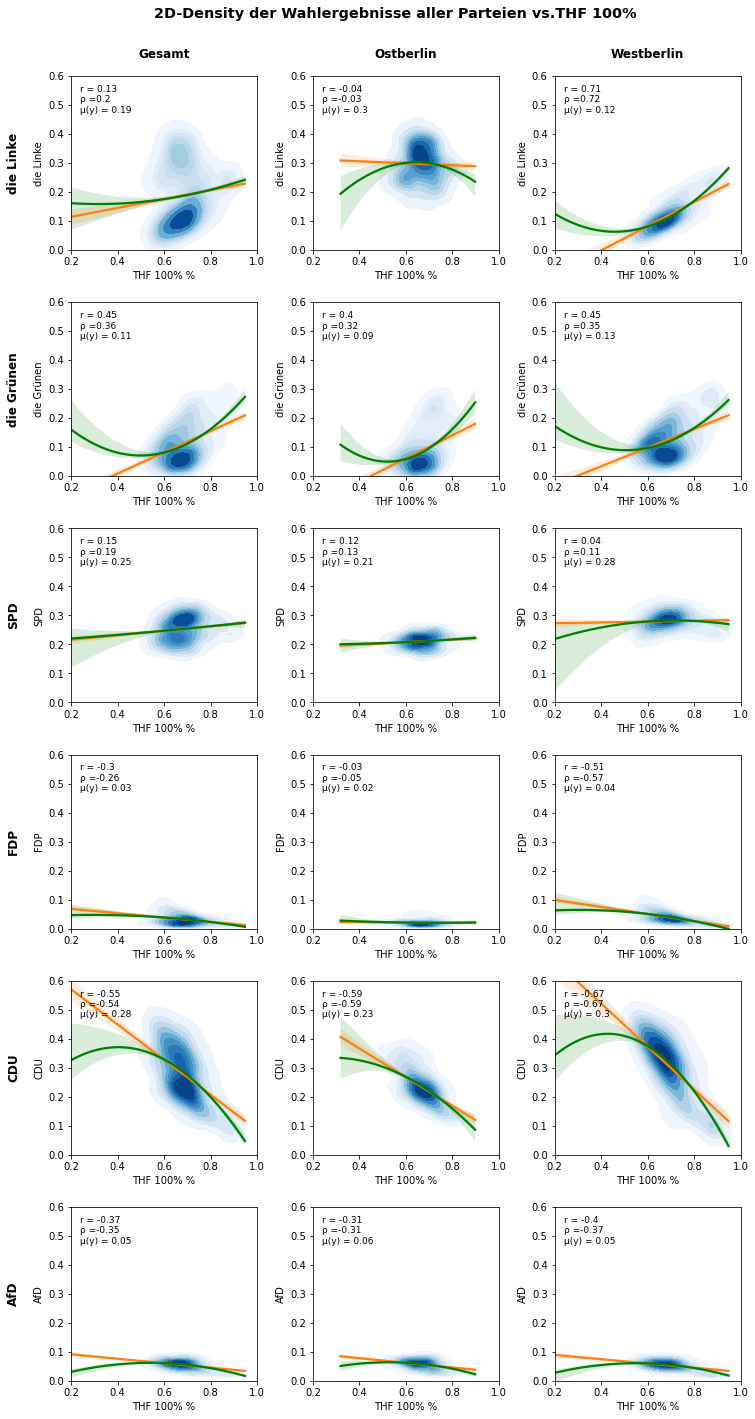

In [14]:
# density plots
dfs = [btw_13_merged, thf_east, thf_west]
plot_2d_density('THF 100%', dfs,  'anteil_ja_thf', 0.2)

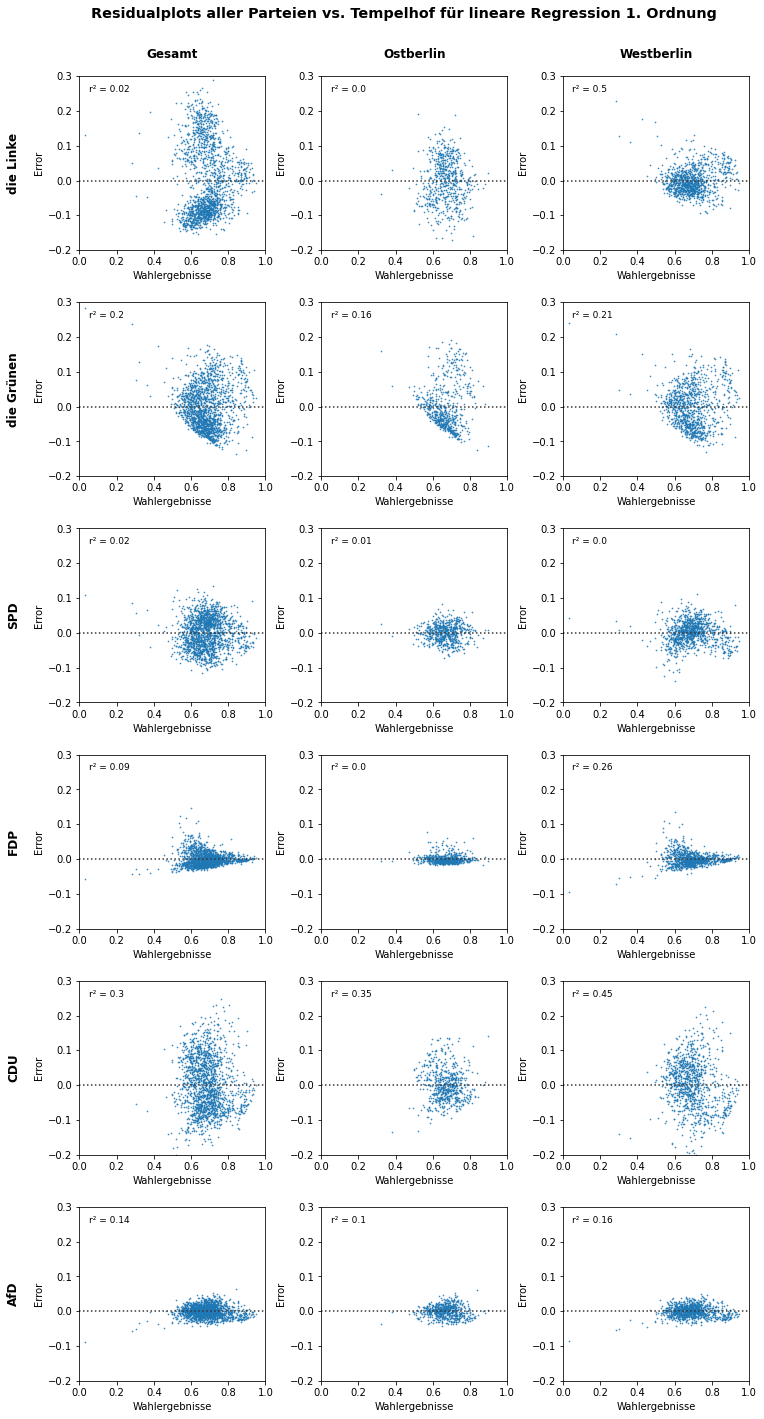

In [15]:
# plot residuals
dfs = [btw_13_merged, thf_east, thf_west]
plot_residuals(plebiscite_title='Tempelhof', dfs=dfs, plebiscite_column_name='anteil_ja_thf', pol_order=1)

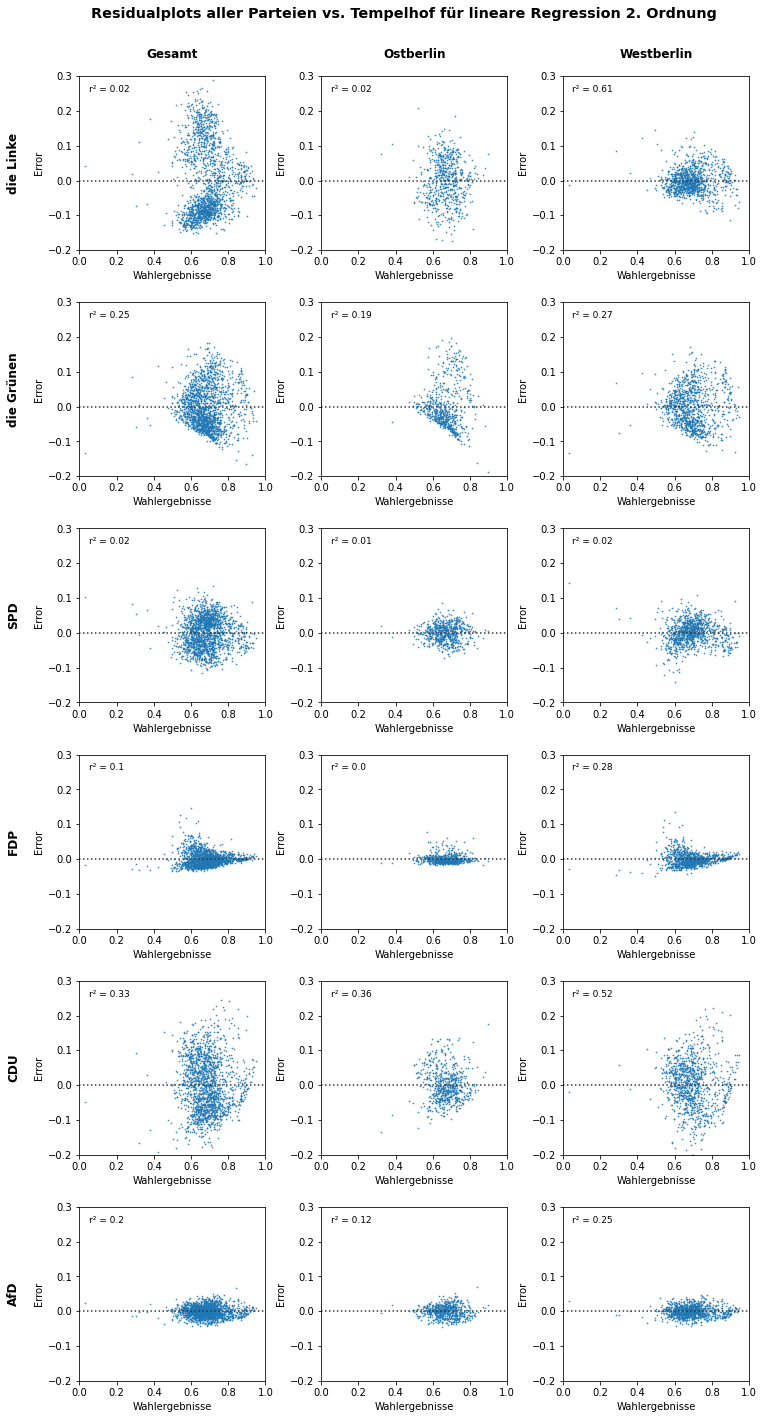

In [16]:
# plot residuals
dfs = [btw_13_merged, thf_east, thf_west]
plot_residuals(plebiscite_title='Tempelhof', dfs=dfs, plebiscite_column_name='anteil_ja_thf', pol_order=2)